In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    # source('../utils_mapping.R')
    source('../utils_plotting.R')
})


# Algorithms (donor within tissue)

In [2]:
tissues <- c('Synovium', 'Gut', 'SalivaryGland', 'Lung')
columns_select <- c('CellID', 'LibraryID', 'Case', 'Tissue', 'Cluster')

In [3]:
umap_df2 <- list(
#     PCA = cbind(
#         readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/umap_before.rds') %>% data.table() %>% 
#                     dplyr::rename(UMAP1=V1, UMAP2=V2),
#         readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/meta_data.rds') %>% 
#             dplyr::select(CellID, LibraryID, Case, Tissue)
#     ),
    Scanorama = cbind(
        glue('../../data/cache/scanorama_donors_{tissues}_umap.csv') %>% map(fread) %>% bind_rows() %>% 
            dplyr::rename(UMAP1=V1, UMAP2=V2),
        glue('../../data/cache/scanorama_donors_{tissues}_meta.csv') %>% map(fread) %>% bind_rows() %>% 
            dplyr::select(contains(columns_select))
    ),
    BBKNN = cbind(
        glue('../../data/cache/bbknn_donors_{setdiff(tissues, \"Lung\")}_umap.csv') %>% map(fread) %>% bind_rows() %>% 
            dplyr::rename(UMAP1=V1, UMAP2=V2),
        glue('../../data/cache/bbknn_donors_{setdiff(tissues, \"Lung\")}_meta.csv') %>% map(fread)  %>% bind_rows() %>% 
            dplyr::select(contains(columns_select))
    ),
    scVI = cbind(
        glue('../../data/cache/scvi_donors_{tissues}_umap.csv') %>% map(fread) %>% bind_rows() %>% 
            dplyr::rename(UMAP1=V1, UMAP2=V2),
        glue('../../data/cache/scvi_donors_{tissues}_meta.csv') %>% map(fread)  %>% bind_rows() %>% 
            dplyr::select(contains(columns_select))
    )
) %>% 
    bind_rows(.id = 'Algorithm')

In [4]:
## BBKNN failed on lung - put placeholder in plots 
umap_df2 <- umap_df2 %>% 
    plyr::rbind.fill(tibble(Algorithm='BBKNN', Tissue='Lung')) %>% 
    dplyr::mutate(
        Algorithm = factor(Algorithm, c('PCA', 'scVI', 'Scanorama', 'BBKNN')),
#         Algorithm = factor(Algorithm, c('scVI', 'Scanorama', 'BBKNN')),
        Tissue = factor(Tissue, c('Gut', 'Synovium', 'SalivaryGland', 'Lung'))
    ) 


In [5]:
palette_custom <- umap_df2 %>% 
    split(.$Tissue) %>% 
    map(function(.SD) {
        x <- unique(.SD$LibraryID)
        y <- colorRampPalette(tableau_color_pal('Tableau 20')(20))(length(x))
        names(y) <- x
        return(y)
    }) %>% 
    reduce(c)


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


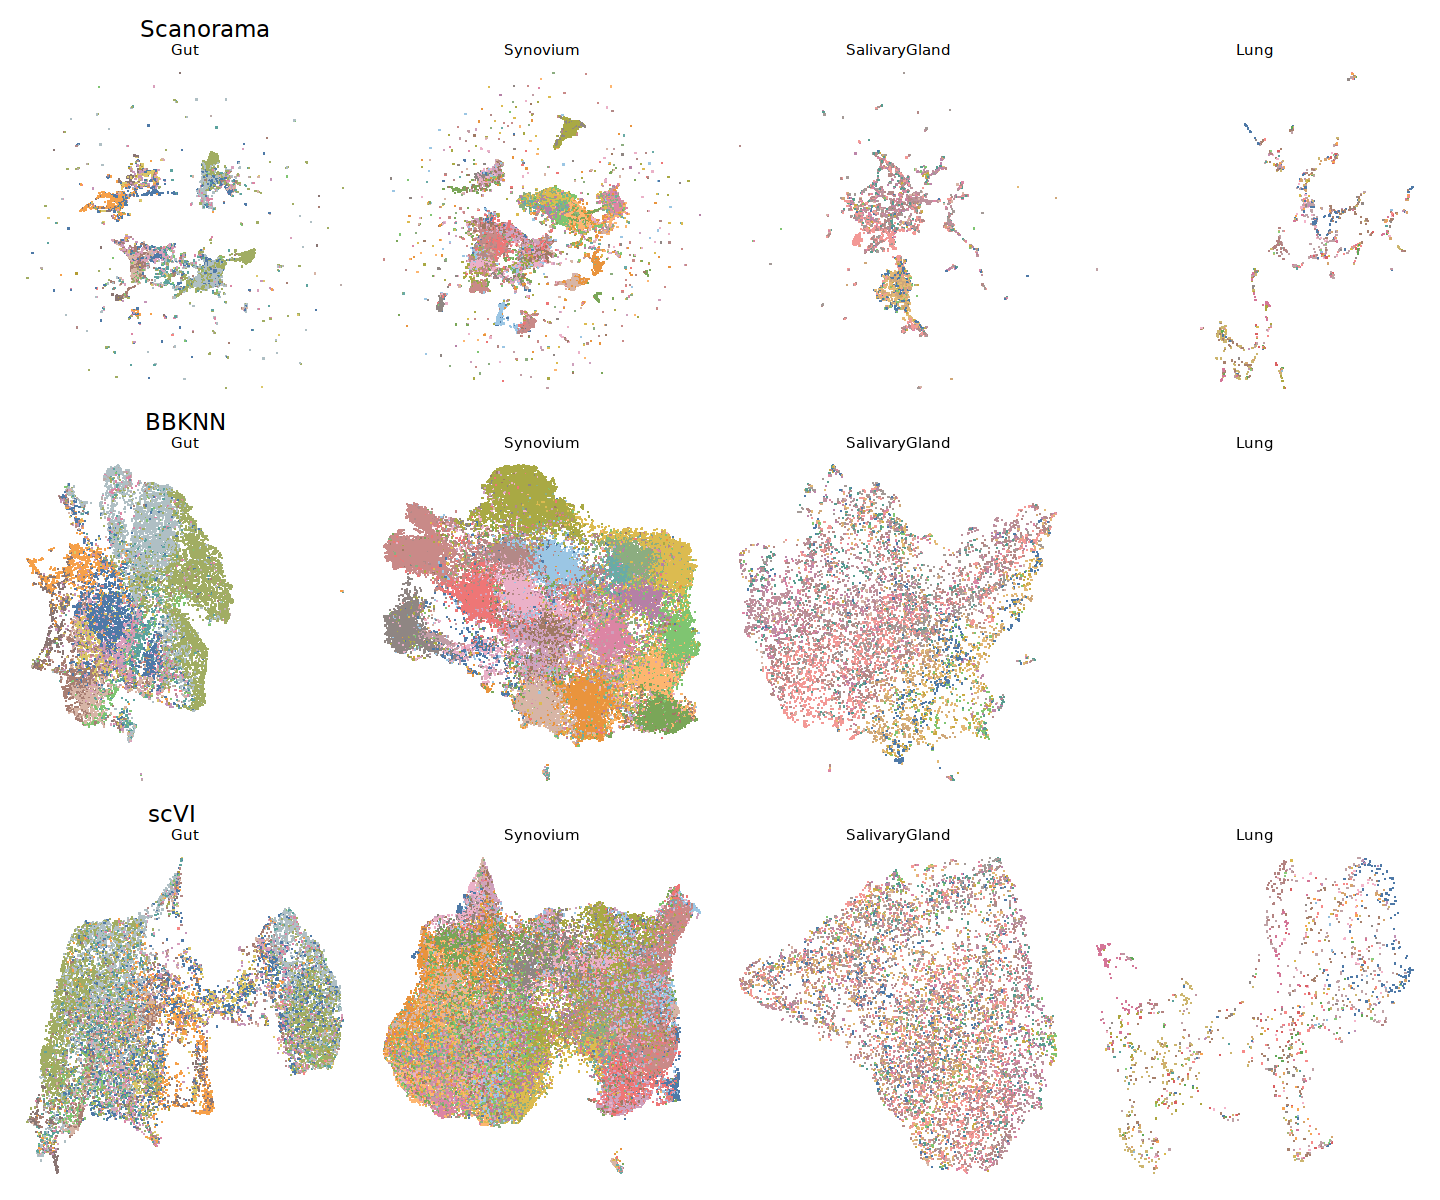

In [6]:
fig.size(10, 12)
p1 <- umap_df2 %>% 
    dplyr::mutate(Algorithm = factor(Algorithm, c('Scanorama', 'BBKNN', 'scVI'))) %>% 
    split(.$Algorithm) %>% 
    imap(function(.SD, .title) {
        do_scatter(
            dplyr::select(.SD, matches('UMAP')),
            dplyr::select(.SD, -matches('UMAP')),
            'LibraryID',
#             palette_use = palette_global[unique(umap_df2$LibraryID)], 
            palette_use = palette_custom, 
            do_labels=FALSE, no_guides=FALSE
        ) + 
            theme_void() + 
            facet_wrap(~ Tissue, scales = 'free', nrow = 1) + 
            guides(color = FALSE, fill = FALSE) + 
            labs(title = .title) + 
            theme(plot.title = element_text(hjust = .1)) + 
            NULL        
    }) %>% 
    reduce(`+`) + 
    plot_layout(ncol = 1) 

p1

# scVI (donors and tissues)

In [7]:
columns_select <- c('CellID', 'LibraryID', 'Case', 'Tissue', 'Cluster')
umap_df <- bind_rows(list(
    fread('../../data/cache/scvi_tissues_umap.csv')[, `:=`(Algorithm='scVI', Variable='Tissue')][] %>% 
    #             cbind(Tissue=fread('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/meta_for_bbknn.csv')$Tissue),
    cbind(
        fread('../../data/cache/obj_fibroblasts/meta_for_bbknn.csv') %>% 
            dplyr::select(contains(columns_select))
    ),
    fread('../../data/cache/scvi_donors_umap.csv')[, `:=`(Algorithm='scVI', Variable='Donor')][] %>% 
    #             cbind(Tissue=fread('/data/srlab2/ik936/Roche/data/cache/scvi_donors_meta.csv')$Tissue),  
    cbind(
        fread('../../data/cache/scvi_donors_meta.csv') %>% 
            dplyr::select(contains(columns_select))
    )
))


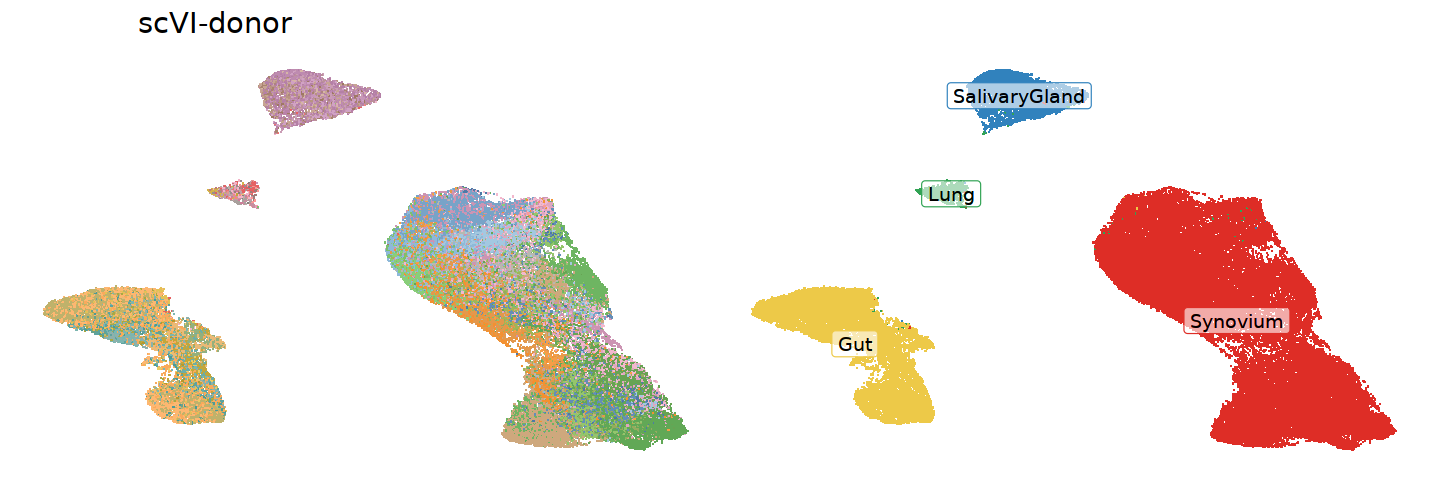

In [8]:
fig.size(4, 12)
p2 <- do_scatter(
    umap_df %>% subset(Variable == 'Donor') %>% dplyr::select(V1, V2),
    umap_df %>% subset(Variable == 'Donor') %>% dplyr::select(-V1, -V2),
    'LibraryID',
    palette_use=colorRampPalette(tableau_color_pal('Tableau 20')(20))(length(unique(umap_df$LibraryID))), 
    do_labels=FALSE, no_guides=TRUE
) + 
    theme_void() + 
do_scatter(
    umap_df %>% subset(Variable == 'Donor') %>% dplyr::select(V1, V2),
    umap_df %>% subset(Variable == 'Donor') %>% dplyr::select(-V1, -V2),
    'Tissue',
    palette_use=palette_global, 
    do_labels=TRUE, no_guides=TRUE
) + 
    plot_annotation(title = 'scVI-donor', theme = theme(plot.title = element_text(hjust=.1))) + 
    theme_void() + 
    NULL
p2


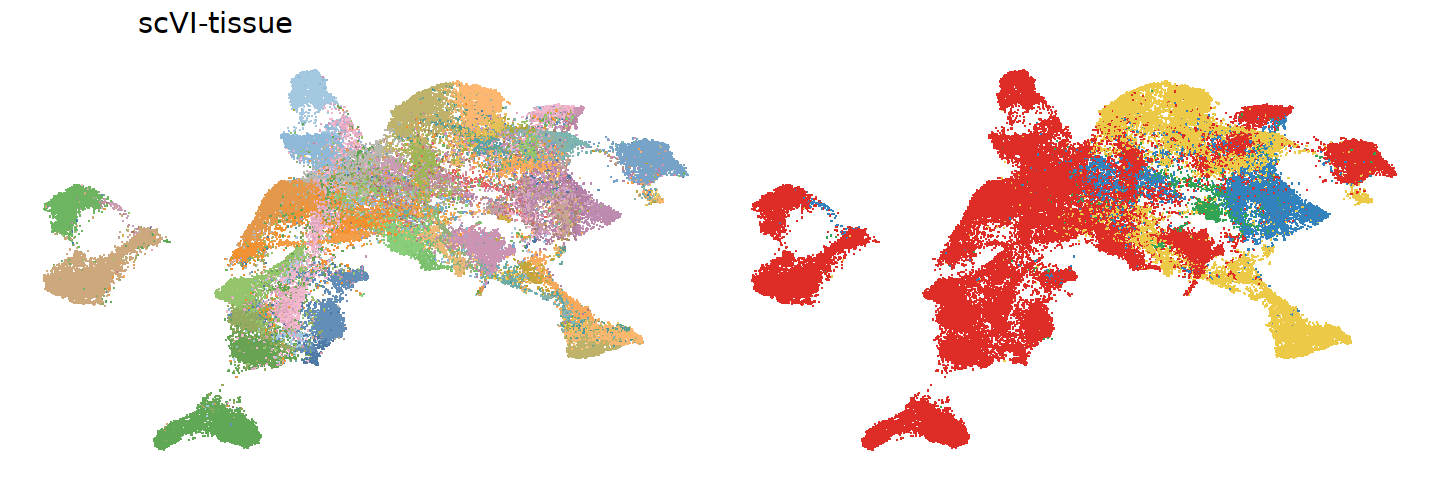

In [9]:
# fig.size(4, 12)
# p3 <- do_scatter(
#     umap_df %>% dplyr::select(V1, V2),
#     umap_df %>% dplyr::select(-V1, -V2) %>% dplyr::mutate(Variable = sprintf('Integrated over %s', Variable)),
#     'Tissue',
#     palette_use=palette_global,
#     do_labels=TRUE, no_guides=TRUE
# ) + 
#     facet_wrap(~Variable, scales = 'free') + 
# #     labs(title = 'scVI Integrate over Tissue', subtitle = 'Colored by Tissue') + 
#     NULL
# p3
fig.size(4, 12)
p3 <- do_scatter(
    umap_df %>% subset(Variable == 'Tissue') %>% dplyr::select(V1, V2),
    umap_df %>% subset(Variable == 'Tissue') %>% dplyr::select(-V1, -V2),
    'LibraryID',
    palette_use=colorRampPalette(tableau_color_pal('Tableau 20')(20))(length(unique(umap_df$LibraryID))), 
    do_labels=FALSE, no_guides=TRUE
) + 
    theme_void() + 
do_scatter(
    umap_df %>% subset(Variable == 'Tissue') %>% dplyr::select(V1, V2),
    umap_df %>% subset(Variable == 'Tissue') %>% dplyr::select(-V1, -V2),
    'Tissue',
    palette_use=palette_global, 
    do_labels=FALSE, no_guides=TRUE
) + 
    theme_void() + 
    plot_annotation(title = 'scVI-tissue', theme = theme(plot.title = element_text(hjust=.1))) + 
    NULL
p3


# Donor-only harmony

In [10]:
U <- readRDS('../../data/cache/harmony_over_donors_umap.rds')
meta4 <- readRDS('../../data/cache/obj_fibroblasts/meta_data.rds')

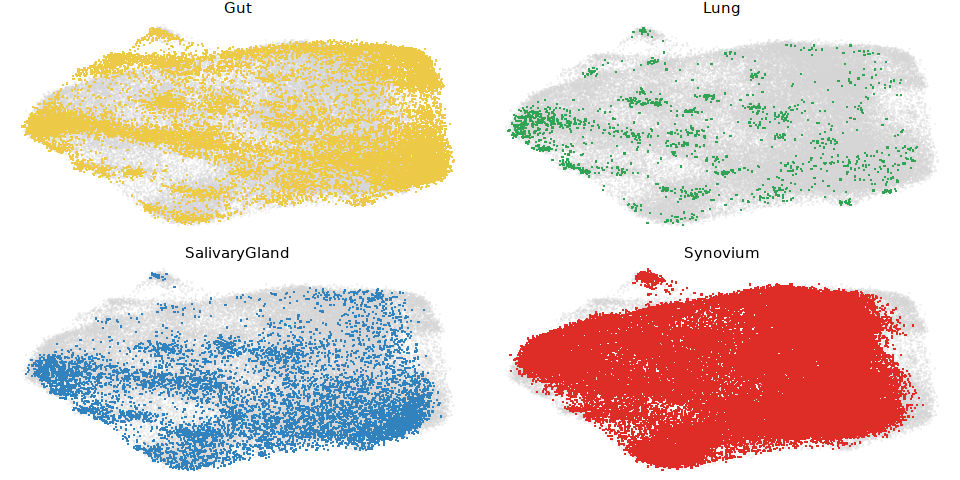

In [11]:
fig.size(4, 8)
p4 <- do_scatter(U, meta4, 'Tissue', quo(Tissue), nrow=2, palette_use=palette_global, do_labels=FALSE) + 
    theme_void()
p4

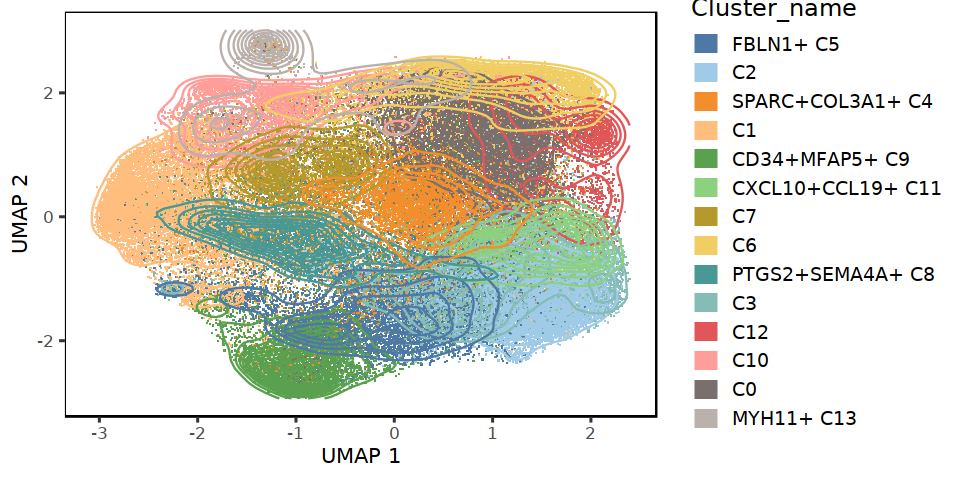

In [12]:
fig.size(4, 8)
p5 <- do_scatter(U, meta4, 'Cluster_name', palette_use=palette_global[unique(meta4$Cluster_name)], do_labels=FALSE, no_guides=FALSE) +
    geom_density_2d() 
p5

# Epithelial integration

In [13]:
obj_epi <- readRDS('../../data/cache/R1C08_obj_epithelial.rds')

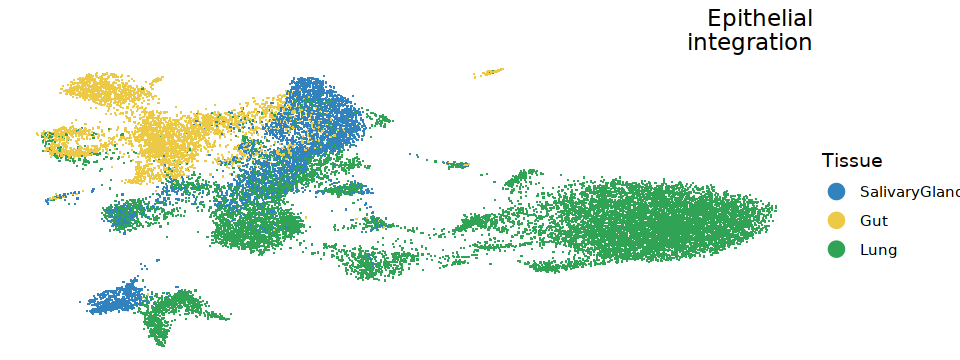

In [14]:
fig.size(3, 8)

# do_scatter(obj_epi$umap_before, obj_epi$meta_data, 'Tissue', palette_use = palette_global[obj_epi$meta_data$Tissue], do_labels = FALSE, no_guides = TRUE) + 
# #     labs(title = 'Before Harmony') + 
#     theme_void() + 
p6 <- do_scatter(obj_epi$umap_after, obj_epi$meta_data, 'Tissue', palette_use = palette_global[obj_epi$meta_data$Tissue], do_labels = FALSE, no_guides = FALSE) + 
#     labs(title = 'After Harmony') + 
    theme_void() + 
    labs(title = 'Epithelial\nintegration') + 
    theme(plot.title = element_text(hjust = 1)) + 
#     plot_annotation(title = 'Epithelial integration', theme = theme(plot.title = element_text(hjust=.1)))

# do_scatter(obj$umap_after, obj$meta_data, 'joint_lineage', palette_use = palette_global) + 
    NULL

p6

# Epithelium + Fibroblasts

In [15]:
obj5 <- readRDS('../../data/cache/obj_R1C9.rds')

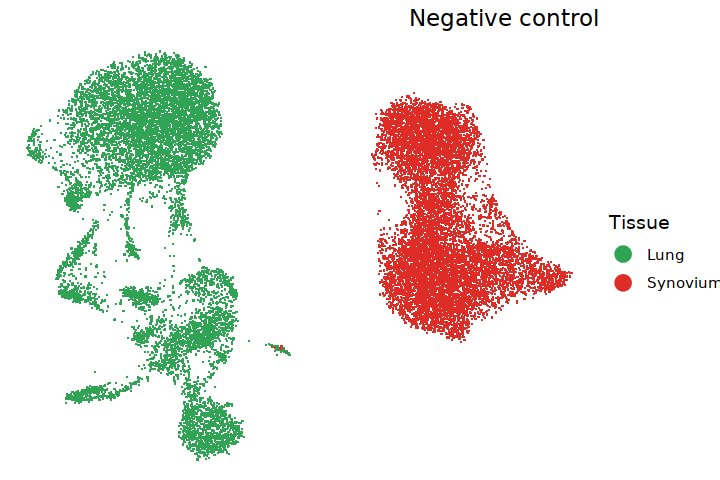

In [16]:
# p7 <- do_scatter(
#     obj5$umap_before, obj5$meta_data, 'Tissue', 
#     palette_use = palette_global[obj5$meta_data$Tissue], do_labels = FALSE, no_guides = TRUE
# ) + 
#     theme_void()

p8 <- do_scatter(
    obj5$umap_after, obj5$meta_data, 'Tissue', 
    palette_use = palette_global[obj5$meta_data$Tissue], do_labels = FALSE, no_guides = FALSE
) + 
    theme_void() + 
    theme(plot.title = element_text(hjust = 1)) + 
    labs(title = 'Negative control')

fig.size(4, 6)
# p7 | p8
p8

# Dataset-specific cluster

## NEW

In [17]:
obj_down <- readRDS('../../data/revision2/R1C07_objdown.rds')

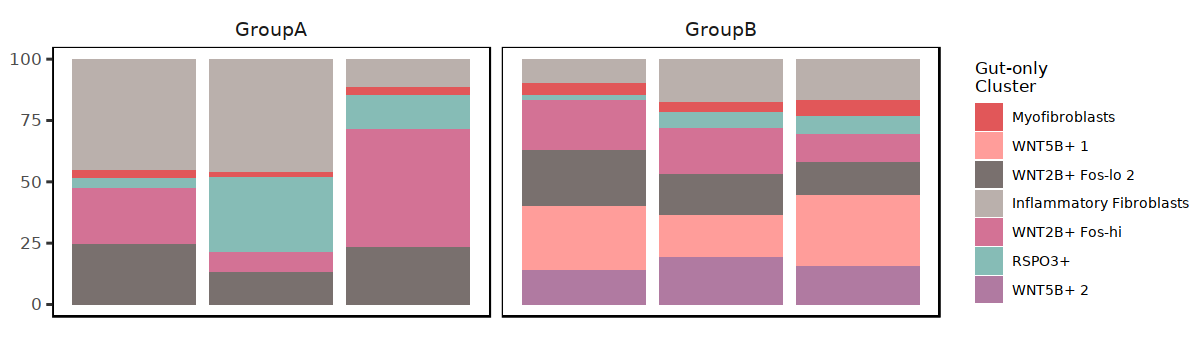

In [18]:
fig.size(3, 10)
p9 <- obj_down$meta_data %>% with(prop.table(table(LibraryID, GroupID, tissue_cell_type), 1)) %>% 
    data.table() %>% 
    subset(N > 0) %>% 
    ggplot(aes(LibraryID, 100 * N, fill = tissue_cell_type)) + 
        geom_bar(stat = 'identity') + 
        # coord_flip() + 
        labs(x = '', y = 'Relative Frequency', fill = 'Gut-only\nCluster') + 
        theme(
            axis.title.y = element_blank(), 
            # axis.text.y = element_blank(),
            # axis.ticks.y = element_blank()
            axis.text.x = element_blank(),
            axis.ticks.x = element_blank(),
            legend.title = element_text(size = 10),
            legend.text = element_text(size = 8)
        ) + 
        scale_fill_manual(values = palette_global[unique(obj_down$meta_data$tissue_cell_type)]) + 
        facet_grid(.~GroupID, scales = 'free', space = 'free') + 
        # facet_grid(GroupID~., scales = 'free', space = 'free') + 
        # labs(subtitle = 'Downsampled datasets') + 
        # guides(fill = 'none') + 
        NULL
p9

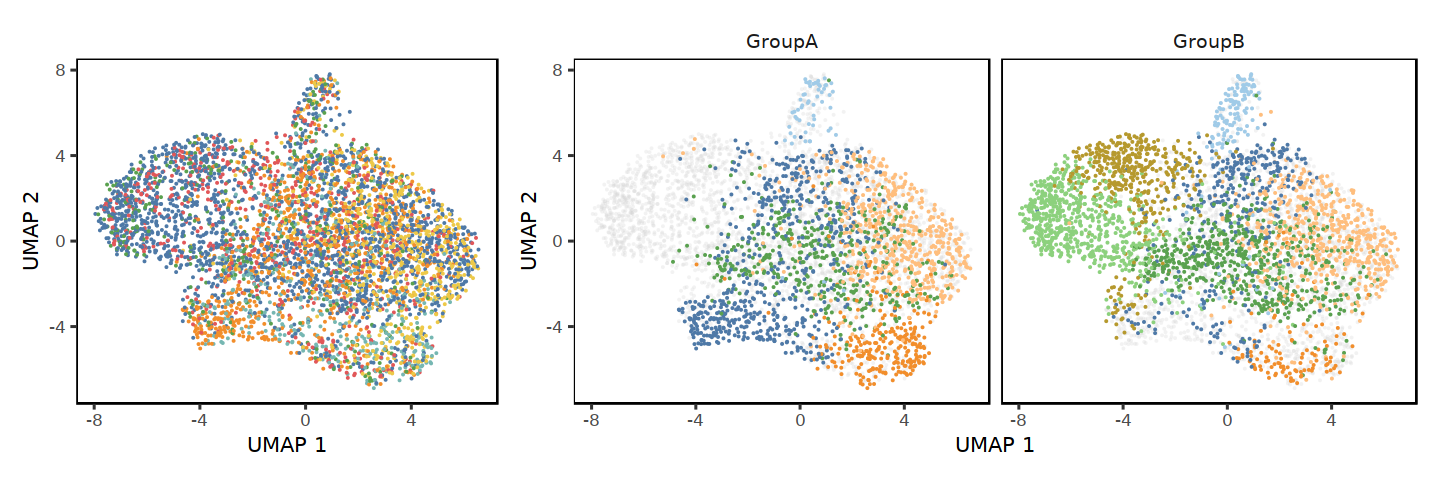

In [19]:
p10 <- do_scatter(
    obj_down$U$embedding, obj_down$meta_data, 
    'LibraryID', 
    pt_shape = 16, 
    palette_use = tableau_color_pal()(6), #[c(2, 4)], 
    do_labels = FALSE, no_guides = TRUE
)

p11 <- do_scatter(
    obj_down$U$embedding, obj_down$meta_data, 
    'tissue_cell_type', quo(GroupID), nrow = 1, 
    pt_shape = 16, 
    # palette_use = palette_global[unique(obj_down$meta_data$tissue_cell_type)], 
    do_labels = FALSE, no_guides = TRUE
) 


fig.size(4, 12)
(p10 | p11) + plot_layout(widths = c(1, 2))

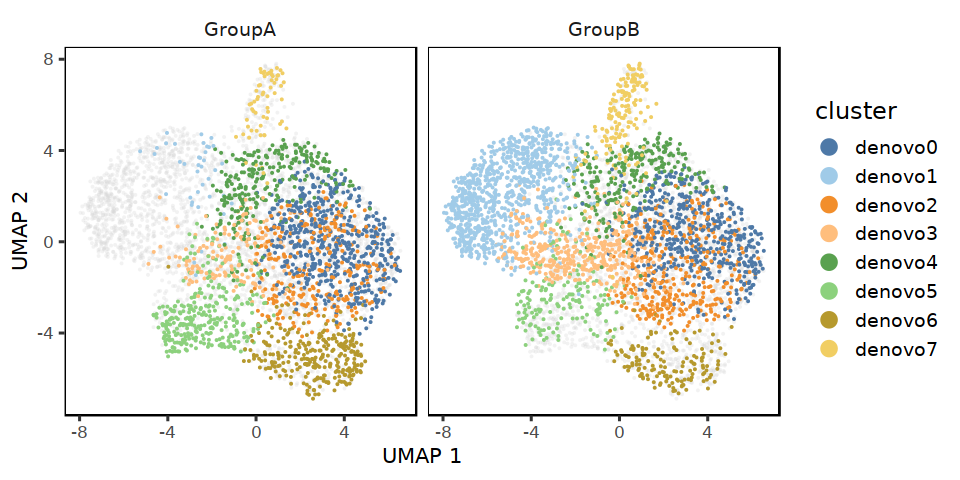

In [20]:
fig.size(4, 8)
p12 <- do_scatter(
    obj_down$U$embedding, cbind(obj_down$meta_data, cluster=paste0('denovo', obj_down$clusters_df$res1)), 'cluster', 
    pt_shape = 16, quo(GroupID), nrow=1,
    do_labels = FALSE, no_guides = FALSE
)
p12

Joining, by = "LibraryID"


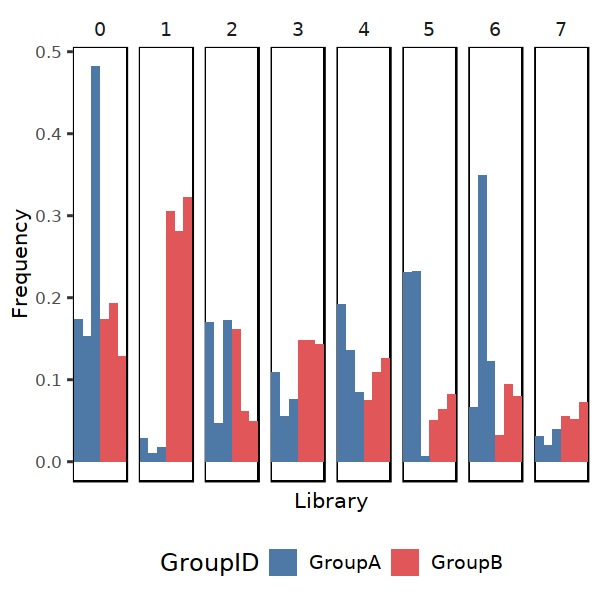

In [21]:
fig.size(5, 5)
p13 <- cbind(obj_down$meta_data, obj_down$clusters_df) %>% 
    with(prop.table(table(LibraryID, res1), 1)) %>% 
    data.table() %>% 
    left_join(unique(dplyr::select(obj_down$meta_data, LibraryID, GroupID))) %>% 
    # subset(res1 == '1') %>% 
    # dplyr::mutate(res1 = paste0('denovo', res1)) %>% 
    ggplot(aes(reorder(LibraryID, as.integer(factor(GroupID))), N, fill = GroupID)) + 
        geom_bar(stat = 'identity') + 
        facet_grid(.~res1, scales = 'free', space = 'free') + 
        # facet_grid(res1~., scales = 'free', space = 'free') + 
        scale_fill_manual(values = tableau_color_pal()(10)[c(1, 3)]) + 
        # coord_flip() + 
        labs(y = 'Frequency', x = 'Library') + 
        theme(
            # axis.text.y = element_blank(),
            # axis.ticks.y = element_blank()
            axis.text.x = element_blank(),
            axis.ticks.x = element_blank(),
            legend.position = 'bottom'
        )
p13

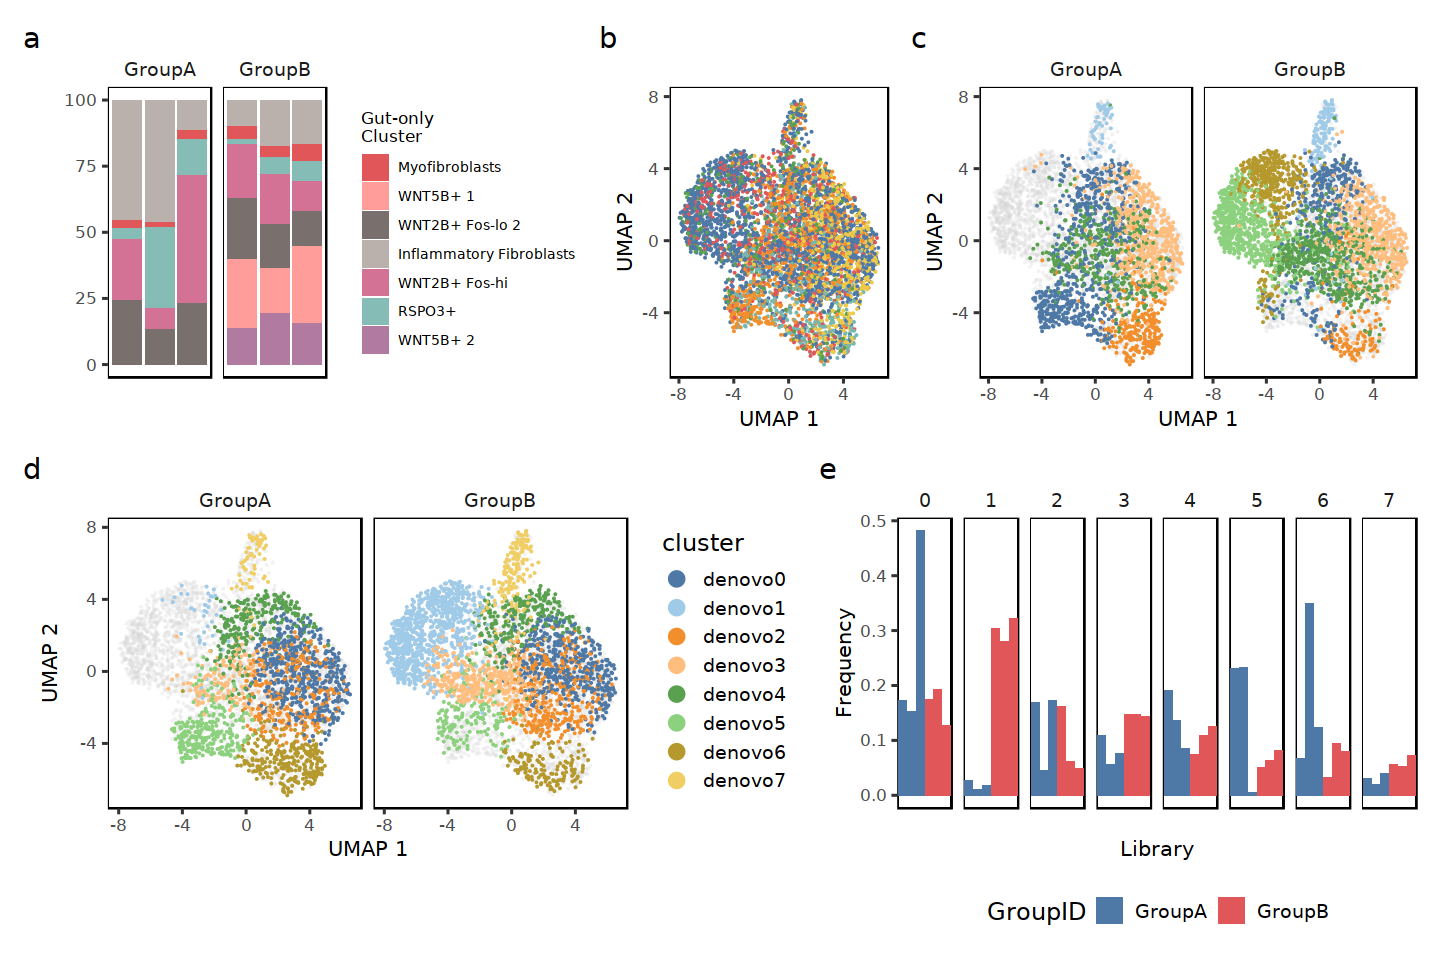

In [22]:
fig.size(8, 12)
(
    (
        (p9 | p10 | p11) + plot_layout(width = c(1, 1, 2))
    ) / 
    (
        (p12 | p13) + plot_layout(width = c(1, 1))
    ) 
) + 
plot_annotation(tag_levels = 'a')


## OLD

In [23]:
# obj_up <- readRDS('../../data/cache/R1C04_objup.rds')
# obj_down <- readRDS('../../data/cache/R1C04_objdown.rds')

# p9a <- do_scatter(
#     obj_up$U$embedding, obj_up$meta_data, 
#     'LibraryID', 
# #     'tissue_cell_type', quo(LibraryID), nrow = 1, 
#     pt_shape = 16, 
#     palette_use = tableau_color_pal()(4)[c(2, 4)], 
#     do_labels = FALSE, no_guides = FALSE
# ) 

# p9b <- do_scatter(
#     obj_up$U$embedding, obj_up$meta_data, 
#     'tissue_cell_type', #quo(LibraryID), nrow = 1, 
# #     'LibraryID', quo(Cluster), nrow = 3, 
#     pt_shape = 16, 
#     palette_use = palette_global, 
#     do_labels = FALSE, no_guides = TRUE
# )  + 
#     facet_wrap(~LibraryID, nrow = 1)  + 
#     theme_void() + 
#     NULL



# fig.size(4, 12)
# (p9a | p9b) + plot_layout(widths = c(1, 2))

# p9c <- do_scatter(
#     obj_down$U$embedding, obj_down$meta_data, 
#     'LibraryID', 
# #     'tissue_cell_type', quo(LibraryID), nrow = 1, 
#     pt_shape = 16, 
#     palette_use = tableau_color_pal()(4)[c(2, 4)], 
#     do_labels = FALSE, no_guides = FALSE
# ) 

# p9d <- do_scatter(
#     obj_down$U$embedding, obj_down$meta_data, 
#     'tissue_cell_type', #quo(LibraryID), nrow = 1, 
# #     'LibraryID', quo(Cluster), nrow = 3, 
#     pt_shape = 16,     
#     palette_use = palette_global, 
#     do_labels = FALSE, no_guides = TRUE
# ) + 
#     facet_wrap(~LibraryID, nrow = 1) +
#     theme_void() + 
#     NULL



# fig.size(4, 12)
# (p9c | p9d) + plot_layout(widths = c(1, 2))

# fig.size(3, 10)
# p10 <- obj_up$meta_data %>% with(prop.table(table(LibraryID, tissue_cell_type), 1)) %>% 
#     data.table() %>% 
#     dplyr::mutate(LibraryID = factor(LibraryID, c('Donor B', 'Donor A'))) %>% 
#     ggplot(aes(LibraryID, 100 * N, fill = tissue_cell_type)) + 
#         geom_bar(stat = 'identity') + 
#         coord_flip() + 
#         labs(x = '', y = 'Relative Frequency', fill = 'Gut-only\nCluster') + 
#         theme(
#             legend.position = 'top',
#             axis.title.y = element_blank(),
#             legend.text = element_text(size = 8),
#             legend.title = element_text(size = 10)
#         ) + 
# #         guides(fill = guide_legend(override.aes = list(stroke = 0, alpha = .8, shape = 21, size = .5)), alpha = FALSE) + 
#         guides(fill = 'none') + 
#         labs(subtitle = 'Full datasets') + 
#         scale_fill_manual(values = palette_global[unique(obj_up$meta_data$tissue_cell_type)]) + 
#         NULL
# p10

# fig.size(3, 10)
# p11 <- obj_down$meta_data %>% with(prop.table(table(LibraryID, tissue_cell_type), 1)) %>% 
#     data.table() %>% 
#     dplyr::mutate(LibraryID = factor(LibraryID, c('Donor B', 'Donor A'))) %>% 
#     ggplot(aes(LibraryID, 100 * N, fill = tissue_cell_type)) + 
#         geom_bar(stat = 'identity') + 
#         coord_flip() + 
#         labs(x = '', y = 'Relative Frequency', fill = 'Gut-only\nCluster') + 
#         theme(
#             legend.position = 'bottom',
#             axis.title.y = element_blank(),
#             legend.text = element_text(size = 8),
# #             legend.title = element_text(size = 10)
#             legend.title = element_blank()
#         ) + 
#         labs(subtitle = 'Downsampled datasets') + 
#         guides(fill = guide_legend(override.aes = list(stroke = 1, size = .25)), alpha = 'none') + 
#         scale_fill_manual(values = palette_global[unique(obj_down$meta_data$tissue_cell_type)]) + 
# #         guides(fill = FALSE) + 
#         NULL
# p11

In [24]:
# fig.size(5, 12)
# (
#     wrap_elements(full = p10) / 
#     (
# #         (p9a | p9b) + plot_layout(widths = c(1, 2))
#         wrap_elements(full = p9b)
#     ) | 
#     wrap_elements(full = p11) / 
#     (
# #         (p9c | p9d) + plot_layout(widths = c(1, 2))
#         wrap_elements(full = p9d)
#     ) 
    
# ) + 
# plot_layout(heights = c(1, 2.5, 1, 2.5)) + 
# plot_annotation(tag_levels = 'a')


# Panels

Warning message:
“Removed 1 rows containing missing values (geom_point).”


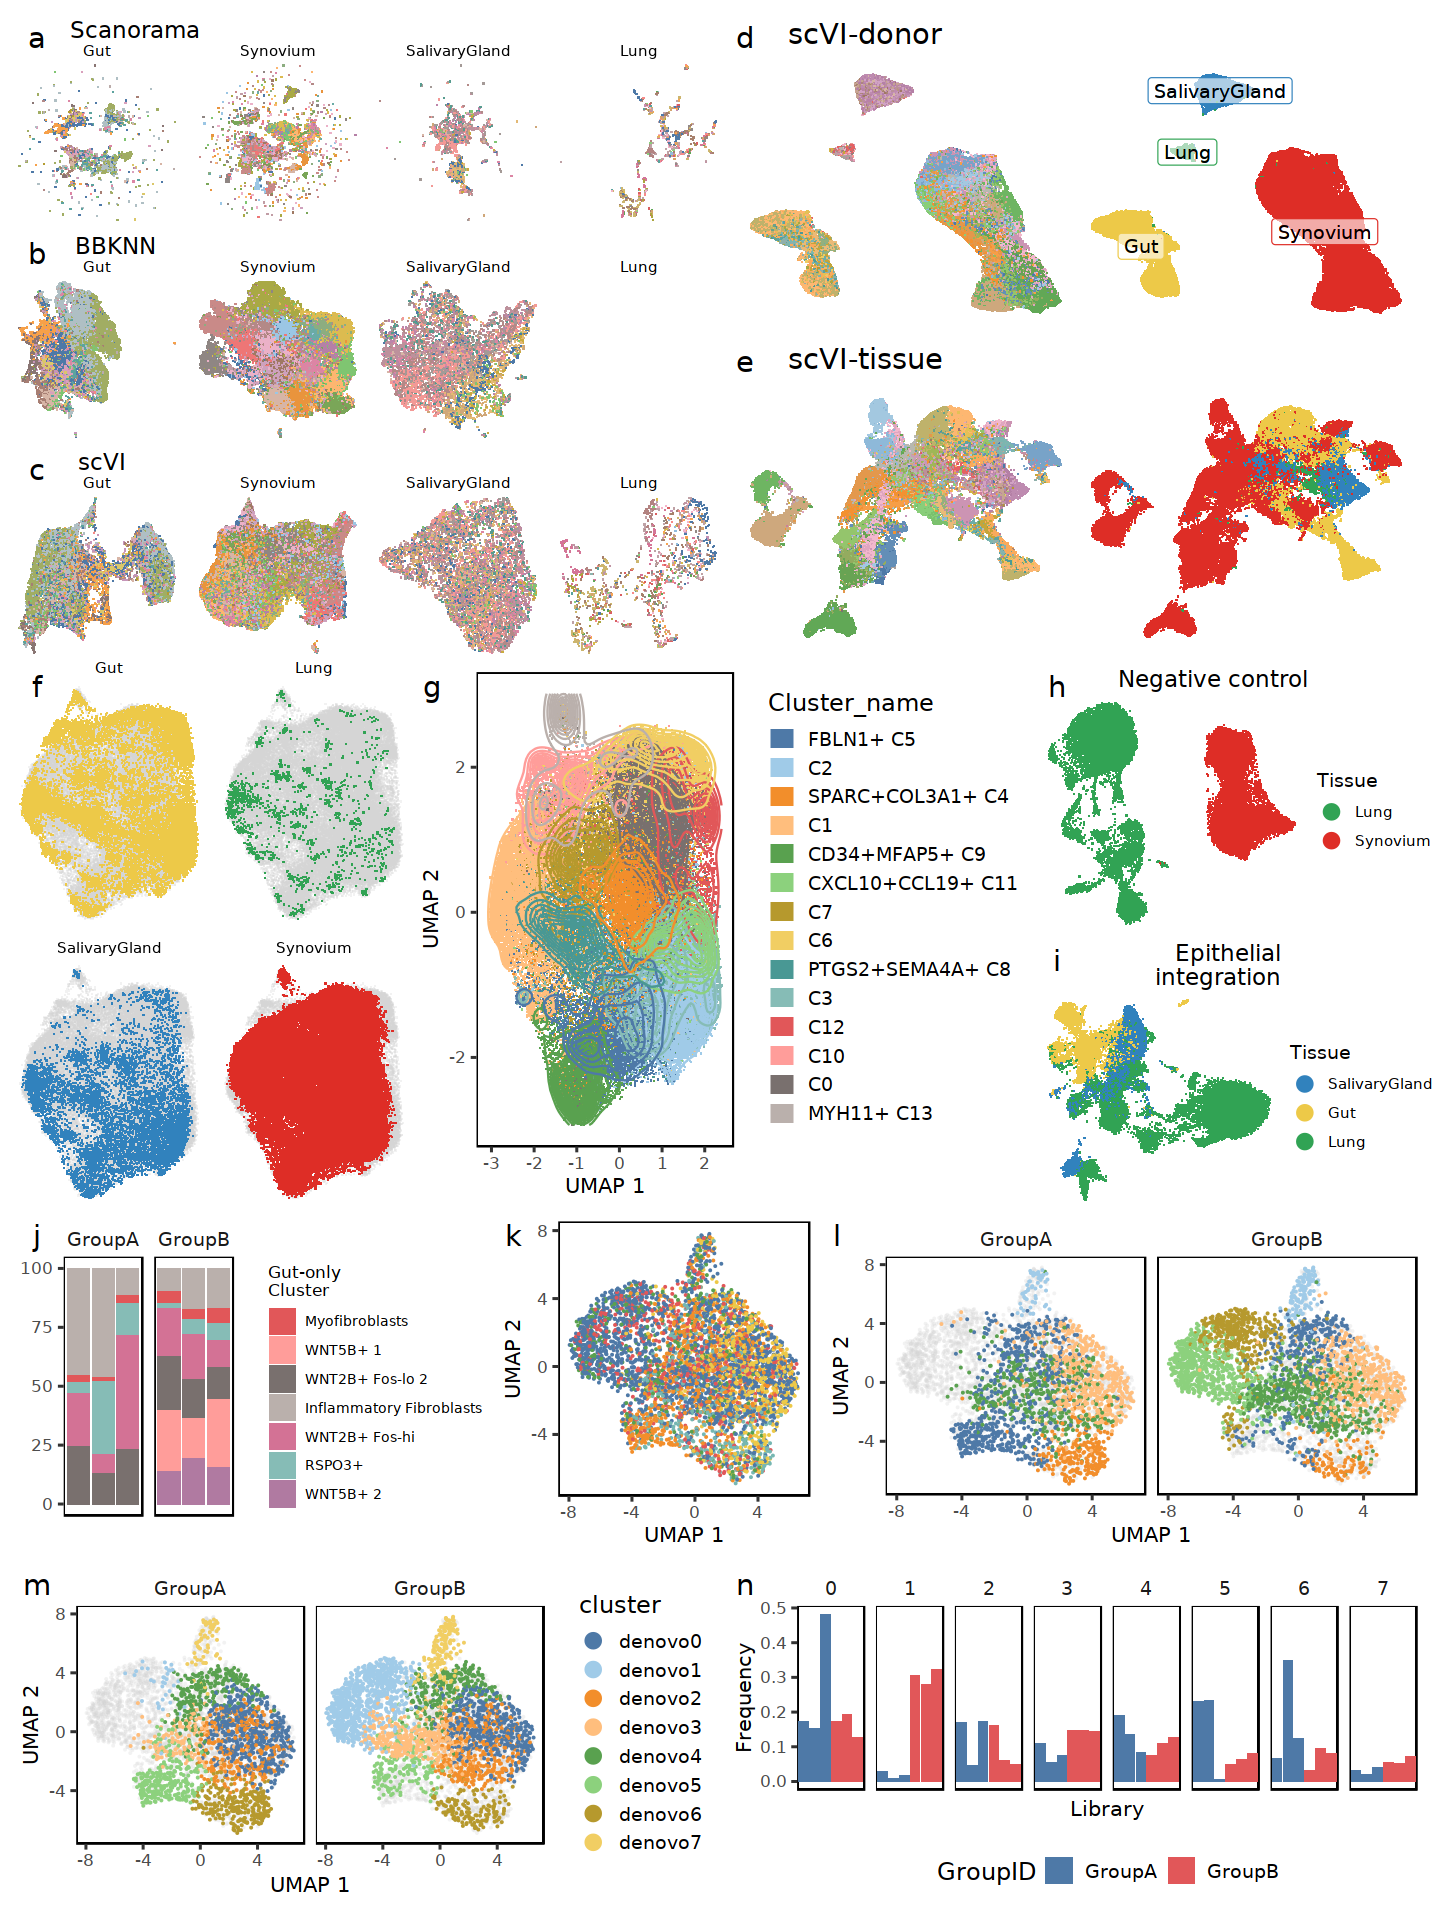

In [25]:
fig.size(16, 12)
plt <- (
    ## Row 1
    (
        (wrap_elements(full = p1[[1]]) / wrap_elements(full = p1[[2]]) / wrap_elements(full = p1[[3]])) |  
        (wrap_elements(full=p2) / wrap_elements(full=p3)) + plot_layout(widths = c(2, 1))    
    )
) / (
    ## Row 2 
    (
        wrap_elements(full = p4) | 
        wrap_elements(full = p5) | 
        (
            wrap_elements(full = p8) / wrap_elements(full = p6)
        )
    ) + 
        plot_layout(widths = c(.6, 1, .6))
) / (
    ## Row 3
    (
        (
            (
                (wrap_elements(full=p9) | wrap_elements(full=p10) | wrap_elements(full=p11)) + plot_layout(width = c(1.5, 1, 2))
                # (p9 | p10 | p11) + plot_layout(width = c(1, 1, 2))
            ) / 
            (
                
                (wrap_elements(full=p12) | wrap_elements(full=p13)) + plot_layout(width = c(1, 1))
                # (p12 | p13) + plot_layout(width = c(1, 1))
            ) 
        )        
        # (
        #     (wrap_elements(full = p10) / wrap_elements(full = p11)) + plot_layout(heights = c(1, 1.8))
        # ) | 
        # (
        #     wrap_elements(full = p9b) / 
        #     wrap_elements(full = p9d)    
        # )
    ) 
) + 

    plot_layout(heights = c(1.2, 1, 1.3)) + 
    plot_annotation(tag_levels = 'a')

plt

In [26]:
ggsave(
    filename = '../../manuscript/figures/SuppFigure3.pdf', 
    plot = plt,
    units = 'in', device = 'pdf', 
    height = 16, width = 12,
    useDingbats = FALSE
)

# ggsave(
#     filename = '/data/srlab2/ik936/Roche/manuscript/figures/SuppFigure3.png', 
#     plot = plt,
#     units = 'in', device = 'png', 
#     height = 12, width = 12
# )


Warning message:
“Removed 1 rows containing missing values (geom_point).”
